In [1]:
import pandas as pd
from sklearn.datasets import fetch_lfw_people
 
faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0,
                         slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)
 
print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


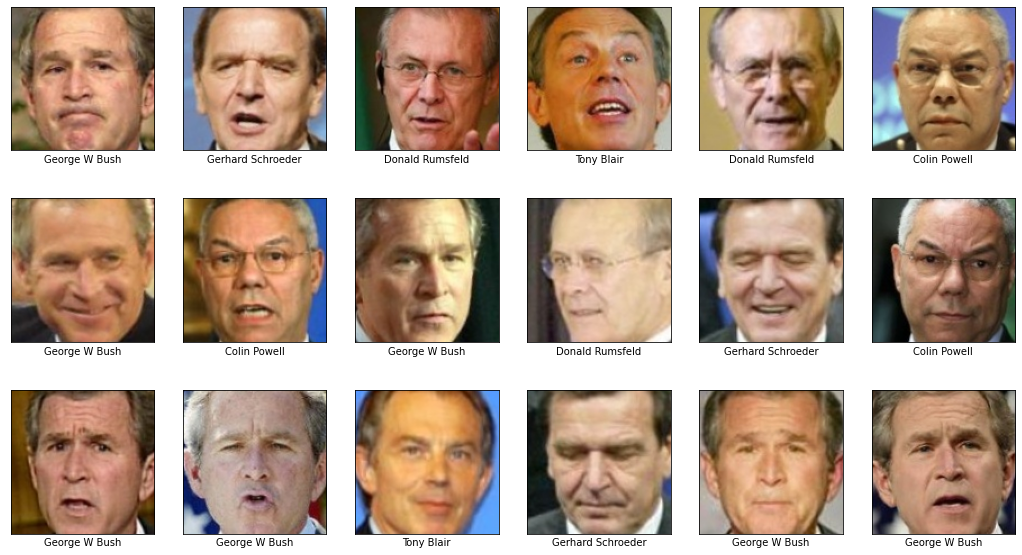

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(3, 6, figsize=(18, 10))
 
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255)
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [3]:
import numpy as np

mask = np.zeros(faces.target.shape, dtype=bool)
 
for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
 
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
 
face_images = preprocess_input(np.array(x_faces))

x_train, x_test, y_train, y_test = train_test_split(face_images, y_faces,
                                                   train_size=0.8, stratify=y_faces,
                                                   random_state=0)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
 
hist = model.fit(x_train / 255, y_train, validation_data=(x_test / 255, y_test),
                 epochs=20, batch_size=10)

Epoch 1/20
40/40 [==============================] - 4s 90ms/step - loss: 1.5257 - accuracy: 0.3200 - val_loss: 1.2448 - val_accuracy: 0.4800
Epoch 2/20
40/40 [==============================] - 3s 84ms/step - loss: 0.8898 - accuracy: 0.6575 - val_loss: 0.9231 - val_accuracy: 0.6500
Epoch 3/20
40/40 [==============================] - 3s 84ms/step - loss: 0.3437 - accuracy: 0.9000 - val_loss: 0.7321 - val_accuracy: 0.7900
Epoch 4/20
40/40 [==============================] - 3s 82ms/step - loss: 0.1454 - accuracy: 0.9450 - val_loss: 0.8574 - val_accuracy: 0.8300
Epoch 5/20
40/40 [==============================] - 3s 81ms/step - loss: 0.0390 - accuracy: 0.9850 - val_loss: 1.3537 - val_accuracy: 0.7400
Epoch 6/20
40/40 [==============================] - 3s 84ms/step - loss: 0.0189 - accuracy: 0.9950 - val_loss: 1.0253 - val_accuracy: 0.8200
Epoch 7/20
40/40 [==============================] - 3s 87ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.1288 - val_accuracy: 0.8400
Epoch 8/20
40

[]

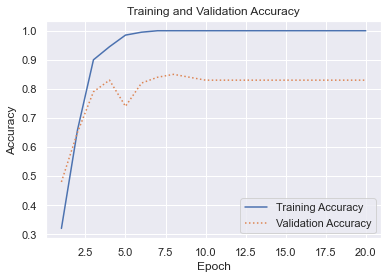

In [6]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [7]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing
 
model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
40/40 [==============================] - 24s 533ms/step - loss: 27.9001 - accuracy: 0.6550 - val_loss: 2.4936 - val_accuracy: 0.8900
Epoch 2/10
40/40 [==============================] - 21s 516ms/step - loss: 0.6281 - accuracy: 0.9625 - val_loss: 3.2732 - val_accuracy: 0.8500
Epoch 3/10
40/40 [==============================] - 21s 518ms/step - loss: 0.5689 - accuracy: 0.9600 - val_loss: 14.7983 - val_accuracy: 0.6600
Epoch 4/10
40/40 [==============================] - 21s 519ms/step - loss: 1.0466 - accuracy: 0.9575 - val_loss: 2.8653 - val_accuracy: 0.9100
Epoch 5/10
40/40 [==============================] - 21s 525ms/step - loss: 0.0061 - accuracy: 0.9975 - val_loss: 1.6654 - val_accuracy: 0.9100
Epoch 6/10
40/40 [==============================] - 21s 517ms/step - loss: 2.4476e-05 - accuracy: 1.0000 - val_loss: 1.5883 - val_accuracy: 0.9200
Epoch 7/10
40/40 [==============================] - 21s 517ms/step - loss: 6.7319e-07 - accuracy: 1.0000 - val_loss: 1.5821 - val_accura

[]

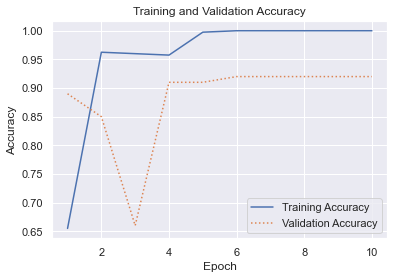

In [9]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 batch_size=10, epochs=10)
 
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [10]:
from tensorflow.keras.models import load_model

base_model = load_model('vggface.h5')
base_model.trainable = False

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
40/40 [==============================] - 13s 265ms/step - loss: 0.2335 - accuracy: 0.9575 - val_loss: 0.0480 - val_accuracy: 0.9900
Epoch 2/10
40/40 [==============================] - 10s 241ms/step - loss: 8.4042e-08 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9900
Epoch 3/10
40/40 [==============================] - 10s 242ms/step - loss: 3.2186e-08 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9900
Epoch 4/10
40/40 [==============================] - 10s 240ms/step - loss: 2.5630e-08 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9900
Epoch 5/10
40/40 [==============================] - 10s 245ms/step - loss: 2.1458e-08 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9900
Epoch 6/10
40/40 [==============================] - 10s 242ms/step - loss: 1.8179e-08 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9900
Epoch 7/10
40/40 [==============================] - 10s 240ms/step - loss: 1.5795e-08 - accuracy: 1.0000 - val_loss: 0.020

[]

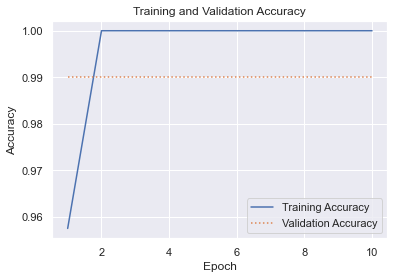

In [12]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 batch_size=10, epochs=10)
 
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

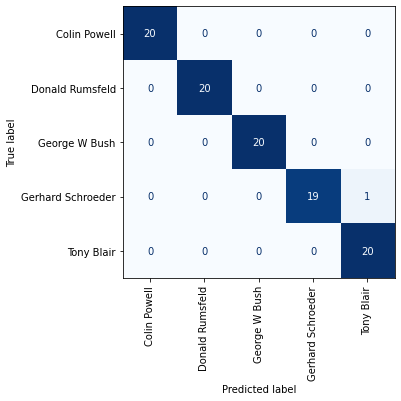

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=faces.target_names, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

In [14]:
from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50', include_top=False)
vggface.build(input_shape=(224, 224, 3))
#vggface.save('vggface.h5')